In [1]:
!pip install torch_geometric
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

#jupytext --to ipynb Comparative_Cheb_GCN.py
# Don't forget to upload model.pth as well
!unzip numpy_data.zip

Saving numpy_data.zip to numpy_data.zip
Saving model_34.pt to model_34.pt
Archive:  numpy_data.zip
  inflating: AdjacencyMatrix.npy     
  inflating: new_data.npy            
  inflating: new_labels.npy          
  inflating: NodeIndex.npy           


In [3]:

import time
start_time = time.time()

#Initiates GNN

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set
from torch_geometric.explain import GNNExplainer
import torch_geometric.transforms as T
import torch
#import torch.nn.functional as F
import os
from tqdm import tqdm, trange
#
import matplotlib.pyplot as plt

#Loading saved model architecture
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.pool import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = GCNConv(6, 512, improved = True)
        # self.conv2 = GCNConv(512, 256, improved = True)

        # self.conv1 = ChebConv(6, 512, K = 2)
        # self.conv2 = ChebConv(512,256, K = 2)

        self.conv1 = ChebConv(6, 256, K = 3)
        self.conv2 = ChebConv(256,256, K = 4)
        self.conv3 = ChebConv(256, 256, K = 5)
        # self.fc1 = Linear(256, 512)
        # self.fc2 = Linear(512, 256)

        # self.conv1 = GATConv(6, 256, heads = 4)
        # self.conv2 = GATConv(256*4,64, heads = 1, concat=False)

        # self.conv1 = TransformerConv(6, 200, heads = 3)
        # self.conv2 = TransformerConv(200*3,256, heads = 1, concat=False)

        self.lin = Linear(256, 24)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # x = self.fc1(x)
        # x = x.relu()
        # x = self.fc2(x)
        # x = x.relu()

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training) #0.5
        x = self.lin(x)

        return x

model = GCN(hidden_channels=464)
print(model)

# print(os.getcwd()+ "/model.pth")
# model_save_location = os.getcwd()+ "/model.pth"
print(os.getcwd()+ "/model_34.pt")
model_save_location = os.getcwd()+ "/model_34.pt"
model.load_state_dict(torch.load(model_save_location, map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(model_save_location))
print(model.conv3)
print(model.state_dict())

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
import networkx as nx
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
print(os.getcwd())

# +
import time
#Extract Training Data
#Loads IEEE34 Bus Simulation Data

path = os.getcwd()

numpy_data = np.load(path+"/new_data.npy",allow_pickle = True)
numpy_data = np.squeeze(numpy_data)
print(numpy_data)
print(numpy_data.shape)
print(numpy_data.size)

value_data = np.load(path+"/new_labels.npy",allow_pickle = True)
print(value_data)
print(value_data.shape)
print(value_data.size)


NodeIndex = np.load(path+"/NodeIndex.npy",allow_pickle = True)
print(NodeIndex)
print(NodeIndex.shape)
print(NodeIndex.size)

AdjacencyMatrix = np.load(path+"/AdjacencyMatrix.npy",allow_pickle = True)
print(AdjacencyMatrix)
print(AdjacencyMatrix.shape)
print(AdjacencyMatrix.size)

# +
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.nn.functional import normalize

encoder = ['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850',
'816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858',
'834', '860', '842', '836', '840', '862', '844', '846', '848', '852r', '888', '856', '852', '864', '838', '890']
print(encoder)
print(len(encoder))
research_paper_decoder = [0,0,1,2,3,4,5,6,6,6,6,7,8,9,10,11,8,12,12,13,14,15,21,15,16,16,16,17,18,18,13,13,19,13,20,22,23]

FaultLocationLabels = value_data[:,3]

for n in range(len(FaultLocationLabels)):
    FaultLocationLabels[n]=research_paper_decoder[encoder.index(str(FaultLocationLabels[n]))]

y = FaultLocationLabels.astype("int64")
y = torch.from_numpy(y)
x = numpy_data.astype("float32")
x = torch.from_numpy(x)

NodeIndex = NodeIndex.astype("int64")
NodeIndex = NodeIndex.T
NodeIndex = torch.from_numpy(NodeIndex)

print(y)
print(y.dtype)
print(x)
print(x.dtype)
print(NodeIndex)
print(NodeIndex.dtype)
#
print(x[0])
print(normalize(x[0]))
#
result_translator = np.unique(FaultLocationLabels.astype("int64")).tolist()
print()
total_data_list = []
for n in range(len(x)):
    #print(x[n])
    #print(y[n])
    DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True) #Testing with non-normalized data
    #DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True)
    DataObject.is_undirected = True
    total_data_list.append(DataObject)
#print('Y'*888)
#print(total_data_list[0].x)

print()
#print(f'Dataset: {total_data_list}:')
print('===================')
print(f'Number of graphs: {len(total_data_list)}')
print(f'Number of features: {total_data_list[0].num_features}')
#print(f'Number of classes: {total_data_list[0].num_classes}')

data = total_data_list[0]  # Get the first graph object.
#print(data)
#print(data.y)

print()
print(NormalizeFeatures(data.x))
print(data.x)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

from random import shuffle
torch.manual_seed(12345)
#total_data_list = total_data_list.shuffle()
shuffle(total_data_list)

train_dataset = total_data_list[:14640] #9150 is half
test_dataset = total_data_list[14640:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


print(test_dataset[0].x)
print(test_dataset[0])
#print(train_dataset[0].x)

for sample in range(len(test_dataset)):
    # noise = np.random.normal(1,0.03, size = (37,6)) #0.09 #Uncomment for noise
    # noise = noise.astype("float32")
    # noise = torch.from_numpy(noise)
    # test_dataset[sample].x = noise*test_dataset[sample].x
    test_dataset[sample].x = normalize(test_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(test_dataset[0].x)
print(test_dataset[0])
##noise = np.random.normal(1,0.09, size = (16,6))
##noise = noise.astype("float32")
##noise = torch.from_numpy(noise)
print('=============================================================')
##
print(train_dataset[0].x)
print(train_dataset[0])
#print(train_dataset[0].x)

for sample in range(len(train_dataset)):
#    noise = np.random.normal(1,0.09, size = (16,6))
#    #    noise = np.random.normal(1,0.09, size = (1,96))
#    noise = noise.astype("float32")
#    noise = torch.from_numpy(noise)
##    print(noise)
##    X_test[sample] = X_test[sample]*noise[0]
#    train_dataset[sample].x = noise*train_dataset[sample].x
    train_dataset[sample].x = normalize(train_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(train_dataset[0].x)
print(train_dataset[0])
##print(noise*test_dataset[0].x)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("$"*200)

#################################################################################

GCN(
  (conv1): ChebConv(6, 256, K=3, normalization=sym)
  (conv2): ChebConv(256, 256, K=4, normalization=sym)
  (conv3): ChebConv(256, 256, K=5, normalization=sym)
  (lin): Linear(in_features=256, out_features=24, bias=True)
)
/content/model_34.pt
ChebConv(256, 256, K=5, normalization=sym)
OrderedDict([('conv1.bias', tensor([ 6.2356e-02, -2.1974e-01, -4.6219e-02, -1.7084e-01, -2.6293e-01,
        -2.6260e-01, -8.5107e-02, -1.3529e-01, -7.8290e-02, -2.3142e-01,
        -3.1671e-01, -1.5598e-01,  8.2232e-02,  1.0987e-01, -2.9260e-01,
        -2.3244e-01, -1.3441e-01, -2.2913e-01, -2.0324e-01, -1.9280e-01,
        -9.8404e-02, -1.4911e-03,  3.1328e-02,  8.7063e-02,  3.2462e-02,
        -8.5882e-02,  1.2128e-01, -3.3120e-02,  2.4983e-02, -6.0169e-02,
        -3.1656e-01, -3.1808e-01, -2.3165e-01,  1.0383e-01, -2.1685e-01,
        -3.6769e-01, -3.2775e-01,  1.6007e-01,  2.7386e-01,  6.3639e-04,
         6.4094e-02,  1.3523e-02, -2.7450e-01, -5.7802e-02, -2.0482e-01,
        -1.1098e-01, -7

<ipython-input-3-c28ac8409384>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_location, map_location=torch.device('cpu')))


2.5.0+cu121
/content
[[[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3453 -75.7 63.3454 164.3 63.3454 44.3]
  [63.2958 -75.8 63.3156 164.2 63.3193 44.2]
  ...
  [72.8754 -79.6 0.0 0.0 0.0 0.0]
  [74.0491 159.9 0.0 0.0 0.0 0.0]
  [11.6445 -80.2 11.8793 159.3 11.8678 39.3]]

 [[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3453 -75.7 63.3453 164.3 63.3453 44.3]
  [63.2762 -75.8 63.2998 164.2 63.3047 44.2]
  ...
  [71.3741 -79.3 0.0 0.0 0.0 0.0]
  [72.7391 160.0 0.0 0.0 0.0 0.0]
  [11.2821 -80.1 11.5595 159.1 11.5487 39.3]]

 [[175.535 -45.7 175.535 -165.7 175.535 74.3]
  [63.3452 -75.7 63.3453 164.3 63.3453 44.3]
  [63.2575 -75.8 63.2846 164.2 63.2905 44.2]
  ...
  [69.9374 -79.0 0.0 0.0 0.0 0.0]
  [71.4786 160.0 0.0 0.0 0.0 0.0]
  [10.937 -80.0 11.2537 158.9 11.2441 39.2]]

 ...

 [[41827.1 30.0 41827.0 -90.0 41827.2 150.0]
  [15093.7 0.0 15093.6 -120.0 15093.7 120.0]
  [14873.2 -0.1 14884.0 -120.1 14882.4 120.0]
  ...
  [537.351 -173.9 0.0 0.0 0.0 0.0]
  [536.45 -174.0 0.0 0.0 0

In [37]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import Explainer, GNNExplainer, GraphMaskExplainer
from torch_geometric.explain import DummyExplainer, PGExplainer
from torch_geometric.nn import GCN
from torch_geometric.utils import k_hop_subgraph


##dataset = ExplainerDataset(
##    graph_generator=BAGraph(num_nodes=300, num_edges=5),
##    motif_generator='house',
##    num_motifs=80,
##    transform=T.Constant(),
##)
#data = test_dataset[0]
#print(data)

from typing import Tuple

import torch
from torch import Tensor

from torch_geometric.explain import Explainer, Explanation
from torch_geometric.explain.config import ExplanationType, ModelMode


pos_fidelity_list = []
neg_fidelity_list = []
characterization_list = []
#topk_list = [1,5,10,15]
topk_list = [10]
# topk_list = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
for topk in topk_list:
    explainer = Explainer(
        model=model,
       algorithm=GNNExplainer(epochs=200),
    #    algorithm=PGExplainer(epochs=2),
        # algorithm=GraphMaskExplainer(num_layers = 3, epochs=200),
      #  algorithm=DummyExplainer(),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='log_probs',
        ),
        threshold_config=dict(
#            threshold_type='topk',
            threshold_type='topk_hard',
            value =topk,
        ),
    )
    count = 0
    explain_y_hat_list = []
    complement_y_hat_list = []
    y_list = []
    y_hat_list = []

    for batch in test_loader:
        count+=1
        Edge_Index = batch.edge_index[:,:72]
        Batch = batch.batch[:37]
        label1 = batch.y[0].numpy().tolist()#
        input = batch.x[0:37]#

        #Uncomment lines below if running the PGExplainer (only supports phenomenon-based explanation)
    #    for epoch in range(2):
    #        loss = explainer.algorithm.train(epoch=epoch, model=model, x = input, edge_index=Edge_Index, batch = Batch)

        y_hat = model(input, Edge_Index, Batch).argmax(dim=1).item()
        explanation = explainer(x = input, edge_index = Edge_Index, batch = Batch)#, target = label1
    #path = 'subgraph.pdf'
    #explanation.visualize_graph(path)
        node_mask = explanation.get('node_mask')
        edge_mask = explanation.get('edge_mask')

        #Two lines below focus on converting the soft masks to hard masks
     #   node_mask = torch.tensor((node_mask-node_mask.mean())>0, dtype=torch.float32)
    #    edge_mask = torch.tensor((edge_mask-edge_mask.mean())>0, dtype=torch.float32)

#        print(node_mask)
#        print(edge_mask)
    #    print("7"*88)
        kwargs = {key: explanation[key] for key in explanation._model_args}
        print(node_mask.dtype)
        print(edge_mask.dtype)
    #    y = explanation.target
        y = label1
        explain_y_hat = explainer.get_masked_prediction(
                explanation.x,
                explanation.edge_index,
                node_mask,
                edge_mask,
                **kwargs,
            )
        explain_y_hat = explainer.get_target(explain_y_hat)
        complement_y_hat = explainer.get_masked_prediction(
            explanation.x,
            explanation.edge_index,
            1. - node_mask if node_mask is not None else None,
            1. - edge_mask if edge_mask is not None else None,
            **kwargs,
        )
        complement_y_hat = explainer.get_target(complement_y_hat)

        explain_y_hat_list.append(explain_y_hat.numpy()[0])
        complement_y_hat_list.append(complement_y_hat.numpy()[0])
        y_list.append(y)
        y_hat_list.append(y_hat)

        print(count)
        print(explain_y_hat.numpy()[0])
        print(complement_y_hat.numpy()[0])
        print(y)
        print(y_hat)
        print("#########")

#        if count > 1:
        # if y_hat==explain_y_hat.numpy()[0] and y_hat not in [12]:
        if y_hat==explain_y_hat.numpy()[0]:
           break


ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.

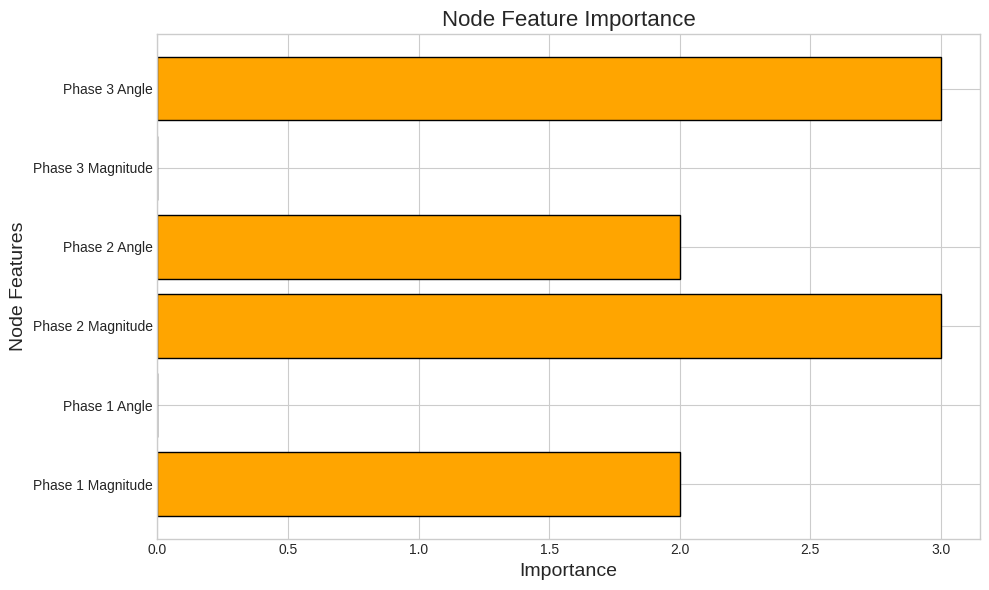

In [5]:
#Node Feature Importance Visualization
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration (replace this with your actual node_mask)
important_nodes = node_mask.numpy().sum(axis=0)

node_features = ['Phase 1 Magnitude', 'Phase 1 Angle', 'Phase 2 Magnitude',
                 'Phase 2 Angle', 'Phase 3 Magnitude', 'Phase 3 Angle']

# Set the style
# plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-v0_8-whitegrid')
# print(plt.style.available)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(node_features, important_nodes, color='orange', edgecolor='black')
# bars = plt.barh(node_features, important_nodes, color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Node Features', fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('Node Feature Importance', fontsize=16)

# # Add value annotations next to each bar
# for bar in bars:
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2),
#              ha='left', va='center', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


{0: 'SRCE', 1: '800', 2: '802', 3: '806', 4: '808', 5: '810', 6: '812', 7: '814', 8: '814R', 9: '850', 10: '816', 11: '818', 12: '824', 13: '820', 14: '822', 15: '826', 16: '828', 17: '830', 18: '854', 19: '832', 20: '858', 21: '834', 22: '860', 23: '842', 24: '836', 25: '840', 26: '862', 27: '844', 28: '846', 29: '848', 30: '852R', 31: '888', 32: '856', 33: '852', 34: '864', 35: '838', 36: '890'}
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 12), (11, 13), (12, 15), (12, 16), (13, 14), (16, 17), (17, 18), (18, 32), (18, 33), (19, 20), (19, 30), (19, 31), (20, 21), (20, 34), (21, 22), (21, 23), (22, 24), (23, 27), (24, 25), (24, 26), (26, 35), (27, 28), (28, 29), (30, 33), (31, 36)]
36
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


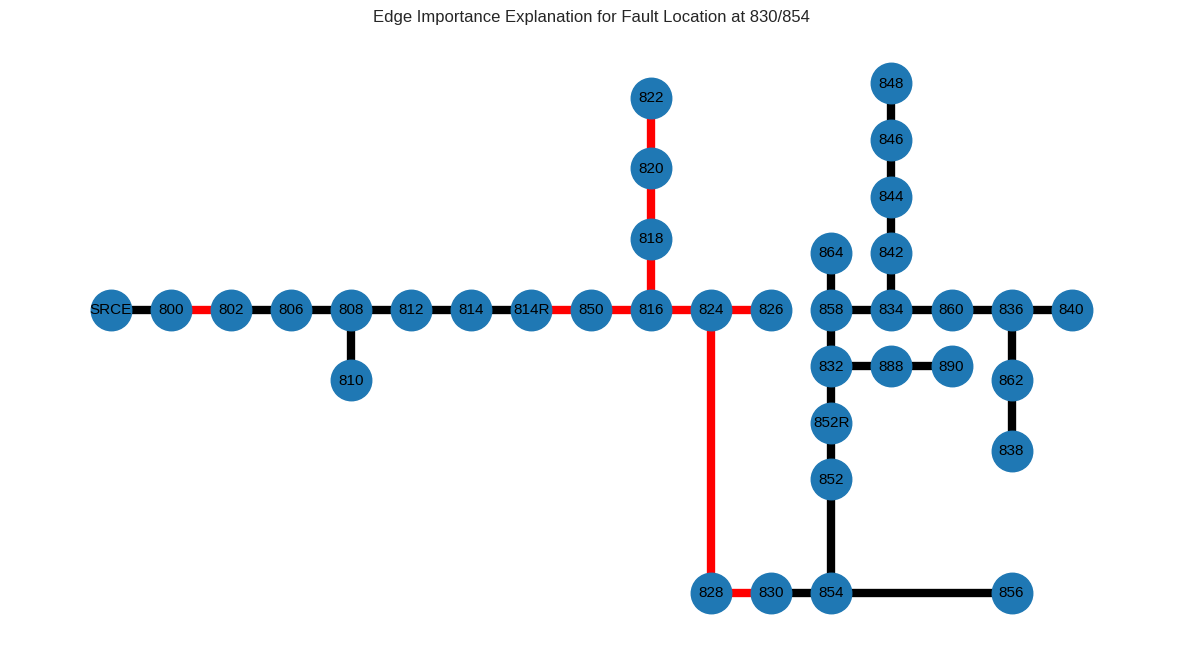

In [33]:
#Graph Importance Visualization
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

BusesInOrder = ['SRCE', '800', '802', '806', '808', '810', '812', '814', '814R', '850', '816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858', '834',
 '860', '842', '836', '840', '862', '844', '846', '848', '852R', '888', '856', '852', '864', '838', '890']
node_labels = {}
for n in range(len(BusesInOrder)):
    node_labels[n] = BusesInOrder[n]
print(node_labels)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(AdjacencyMatrix)
print(G.edges())
print(len(G.edges()))
print(edge_mask)
print(len(edge_mask.numpy()))

pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (3, 0),
    4: (4, 0),
    5: (4, -0.25),
    6: (5, 0),
    7: (6, 0),
    8: (7, 0),
    9: (8, 0),
    10: (9, 0),
    11: (9, 0.25),
    12: (10, 0),
    13: (9, 0.50),
    14: (9, 0.75),
    15: (11, 0),
    16: (10, -1),
    17: (11, -1),
    18: (12, -1),
    19: (12, -0.20),
    20: (12, 0),
    21: (13, 0),
    22: (14, 0),
    23: (13, 0.2),
    24: (15, 0),
    25: (16, 0),
    26: (15, -0.25),
    27: (13, 0.4),
    28: (13, 0.6),
    29: (13, 0.8),
    30: (12, -0.4),
    31: (13, -0.20),
    32: (15, -1),
    33: (12, -0.6),
    34: (12, 0.2),
    35: (15, -0.5),
    36: (14, -0.20)
}

edge_labels = {}
colors = []
for n in range(len(NodeIndex.numpy()[0])):
  if int(edge_mask.numpy()[n])==1:
    edge_labels[(NodeIndex.numpy()[0][n], NodeIndex.numpy()[1][n])] = (1, 0, 0)
    colors.append((1, 0, 0))
    # print("red")
  else:
    edge_labels[(NodeIndex.numpy()[0][n], NodeIndex.numpy()[1][n])] = (0, 0, 0)
    colors.append((0, 0, 0))
  # print(n)

#Translating edges for visualization
colors_36 = []
for n in range(36):
  if colors[:36][n] == (1, 0, 0) or colors[36:][n] == (1, 0, 0):
    colors_36.append((1, 0, 0))
  else:
    colors_36.append((0, 0, 0))
print(colors_36)


# for n in edge_labels.items():
#   print(n)

# Draw the graph
confusion_mat_labels = ["Src/800", "802","806","808","810","812","814/850/816","818","824/828","820","822","826","830/854","852/832/888","858",
        "834/842","836/840/862","844","846/848","856","864","860","838","890"]
plt.figure(figsize=(15, 8))
Title = 'Edge Importance Explanation for Fault Location at ' + confusion_mat_labels[y_hat_list[-1]]
plt.title(Title)
nx.draw(G, pos, with_labels=True, node_size=850, labels = node_labels, edge_color=colors_36, linewidths=1, width = 6, font_size=11, vmin=0.0, vmax=1.0)


# Display the plot
# plt.figure(figsize=(20, 18))
plt.show()

In [20]:
print(AdjacencyMatrix)
print(AdjacencyMatrix.shape)

print(colors)
print(type(colors))
print(len(colors))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(37, 37)
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
<class 'list'>
72


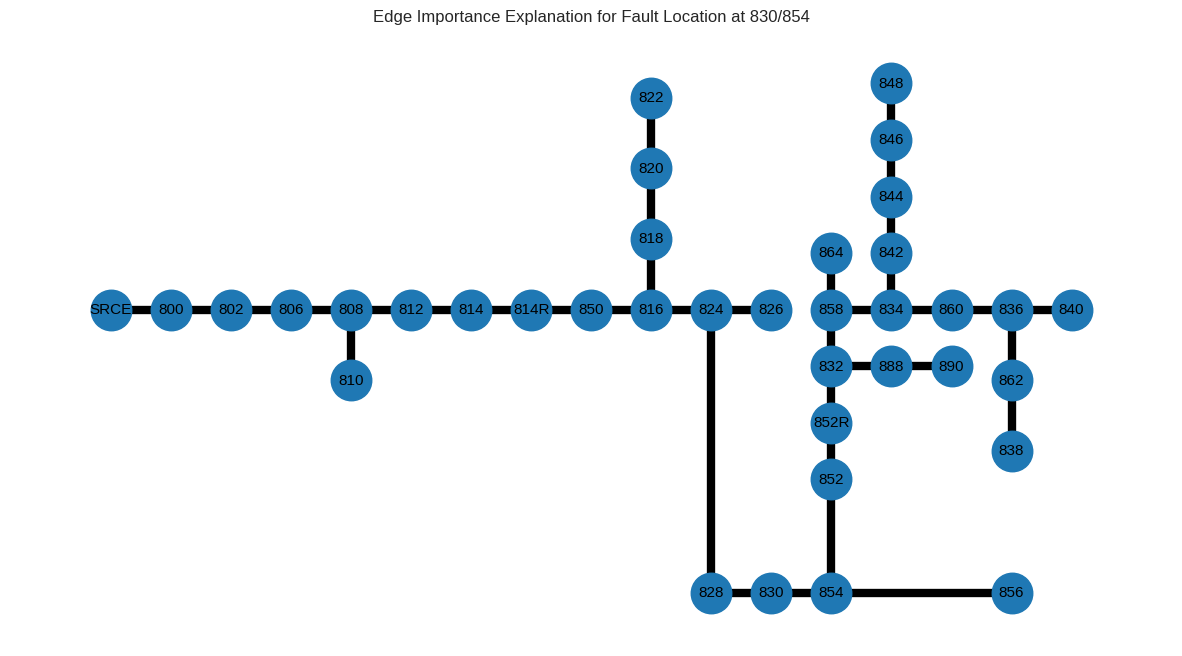

In [16]:
# Ensure the colors list is constructed correctly
edge_labels = {}
colors = []

for n in range(len(NodeIndex.numpy()[0])):
    if int(edge_mask.numpy()[n]) == 1:
        color = (1, 0, 0)  # Red for significant edges
    else:
        color = (0, 0, 0)  # Black for insignificant edges
    edge_labels[(NodeIndex.numpy()[0][n], NodeIndex.numpy()[1][n])] = color
    colors.append(color)

# Verify if colors length matches the number of edges in the graph
assert len(colors) == len(G.edges()), "Colors list length does not match number of edges."

# Draw the graph
confusion_mat_labels = ["Src/800", "802","806","808","810","812","814/850/816","818","824/828","820","822","826","830/854","852/832/888","858",
        "834/842","836/840/862","844","846/848","856","864","860","838","890"]
plt.figure(figsize=(15, 8))
Title = 'Edge Importance Explanation for Fault Location at ' + confusion_mat_labels[y_hat_list[-1]]
plt.title(Title)

# Check the colors for each edge
nx.draw(G, pos, with_labels=True, node_size=850, labels=node_labels, edge_color=colors, linewidths=1, width=6, font_size=11)
plt.show()
